# PUMP IT

Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

An interactive course exploring this dataset is currently offered by DataCamp.com!

Competition End Date: Jan. 28, 2017, 11:59 p.m.

This competition is for learning and exploring, so the deadline may be extended in the future.


* [Git Hub Repo](https://github.com/msampathkumar/datadriven_pumpit)
* [Git Hub Report](https://github.com/msampathkumar/datadriven_pumpit/blob/master/capstone_proposal.mdown)
* [Features Details](https://www.drivendata.org/competitions/7/page/25/)



## Global Imports

In [230]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(69572)

%matplotlib inline

%load_ext writeandexecute

# plt.figure(figsize=(120,10))

# plot figsize
small = (4,3)
mid = (10, 8)
large = (12, 8)

The writeandexecute extension is already loaded. To reload it, use:
  %reload_ext writeandexecute


## Custom Functions

### MarkUP Fns

In [2]:
from __future__ import absolute_import
from IPython.core.getipython import get_ipython
from IPython.core.magic import (Magics, magics_class,  cell_magic)
import sys
from StringIO import StringIO
from markdown import markdown
from IPython.core.display import HTML
 
@magics_class
class MarkdownMagics(Magics):
 
    @cell_magic
    def asmarkdown(self, line, cell):
        buffer = StringIO()
        stdout = sys.stdout
        sys.stdout = buffer
        try:
            exec(cell, locals(), self.shell.user_ns)
        except:
            sys.stdout = stdout
            raise
        sys.stdout = stdout
        return HTML("<p>{}</p>".format(markdown(buffer.getvalue(), extensions=['markdown.extensions.extra'])))
        return buffer.getvalue() + 'test'
 
get_ipython().register_magics(MarkdownMagics)

### DataFrame Value Counts

In [3]:
import pandas as pd

def raw_markup_value_counts(dataframe, max_print_value_counts=30, show_plots=False):
    '''
    prints value counts of each feature in data frame
    '''
    mydf = pd.DataFrame.copy(dataframe)
    i = 0
    raw_markup_data = []
    pp = raw_markup_data.append
    pp('''|Col ID|Col Name|UniqCount|Col Values|UniqValCount|''')
    pp('''|------|--------|---------|----------|------------|''')
    for col in mydf.dtypes.index:
        i += 1
        sam = mydf[col]
        tmp = len(sam.value_counts())
        if tmp < max_print_value_counts:
            flag = True
            for key, val in dict(sam.value_counts()).iteritems():
                if flag:
                    pp('|%i|%s|%i|%s|%s|' % (
                            i, col, len(sam.value_counts()), key, val))
                    flag = False
                else:
                    pp('||-|-|%s|%s|' % (key, val))
            if show_plots:
                plt.figure(i)
                ax = sam.value_counts().plot(kind='barh', figsize=(12, 5))
                _ = plt.title(col.upper())
                _ = plt.xlabel('counts')
        else:
            pp('|%i|%s|%i|||' % (i, col, len(sam.value_counts())))
    return raw_markup_data

#### Confusion Matrix

In [4]:
from sklearn.metrics import confusion_matrix

import itertools

from __future__ import division

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')    

    
def confusion_maxtrix_stuff(y_test, y_pred, class_names=RAW_y.status_group.value_counts().keys()):

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure(figsize=(8,8))
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure(figsize=(8,8))
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

## Import & Explore Data

In [36]:
RAW_X = pd.read_csv('traning_set_values.csv', index_col='id')
RAW_y = pd.read_csv('training_set_labels.csv', index_col='id')
test_submission = pd.read_csv('test_set_values.csv', index_col='id')

In [6]:
RAW_X.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [7]:
RAW_X.head().T

id,69572,8776,34310,67743,19728
amount_tsh,6000,0,25,0,0
date_recorded,2011-03-14,2013-03-06,2013-02-25,2013-01-28,2011-07-13
funder,Roman,Grumeti,Lottery Club,Unicef,Action In A
gps_height,1390,1399,686,263,0
installer,Roman,GRUMETI,World vision,UNICEF,Artisan
longitude,34.9381,34.6988,37.4607,38.4862,31.1308
latitude,-9.85632,-2.14747,-3.82133,-11.1553,-1.82536
wpt_name,none,Zahanati,Kwa Mahundi,Zahanati Ya Nanyumbu,Shuleni
num_private,0,0,0,0,0
basin,Lake Nyasa,Lake Victoria,Pangani,Ruvuma / Southern Coast,Lake Victoria


In [8]:
RAW_X.dtypes[RAW_X.dtypes == object]

date_recorded            object
funder                   object
installer                object
wpt_name                 object
basin                    object
subvillage               object
region                   object
lga                      object
ward                     object
public_meeting           object
recorded_by              object
scheme_management        object
scheme_name              object
permit                   object
extraction_type          object
extraction_type_group    object
extraction_type_class    object
management               object
management_group         object
payment                  object
payment_type             object
water_quality            object
quality_group            object
quantity                 object
quantity_group           object
source                   object
source_type              object
source_class             object
waterpoint_type          object
waterpoint_type_group    object
dtype: object

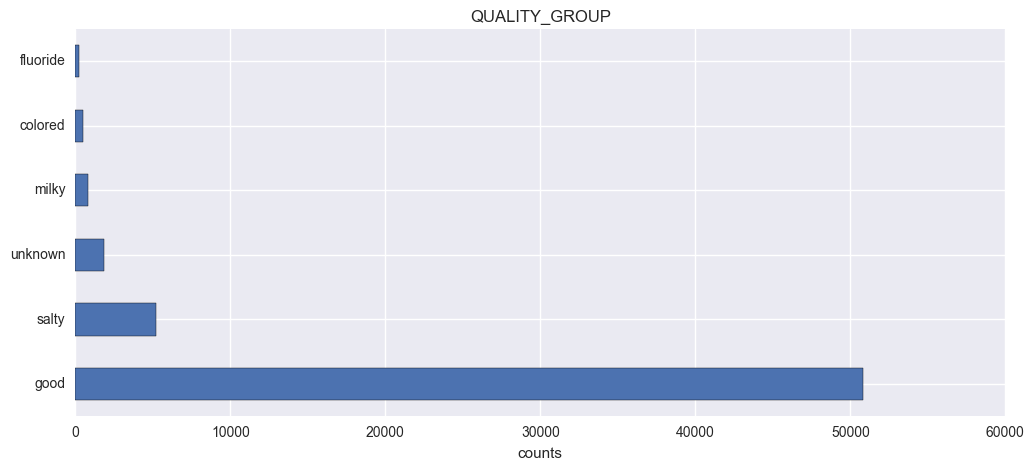

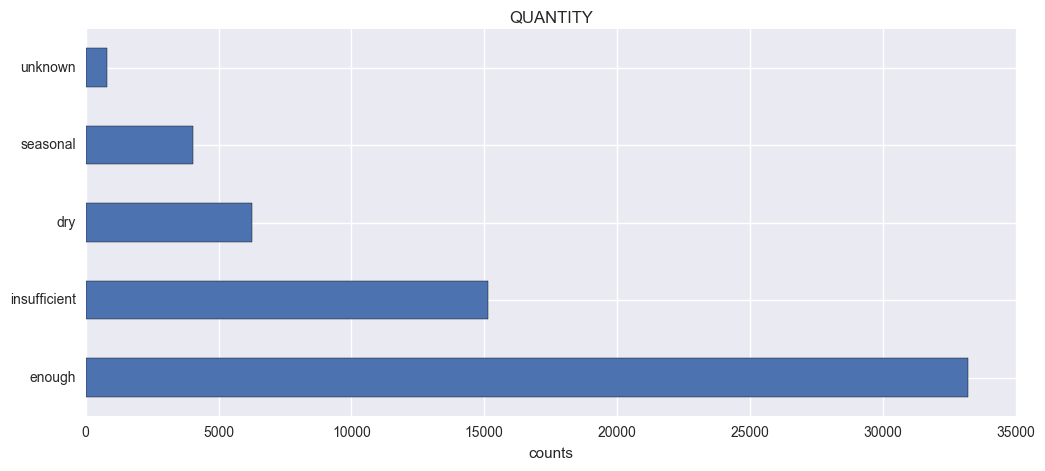

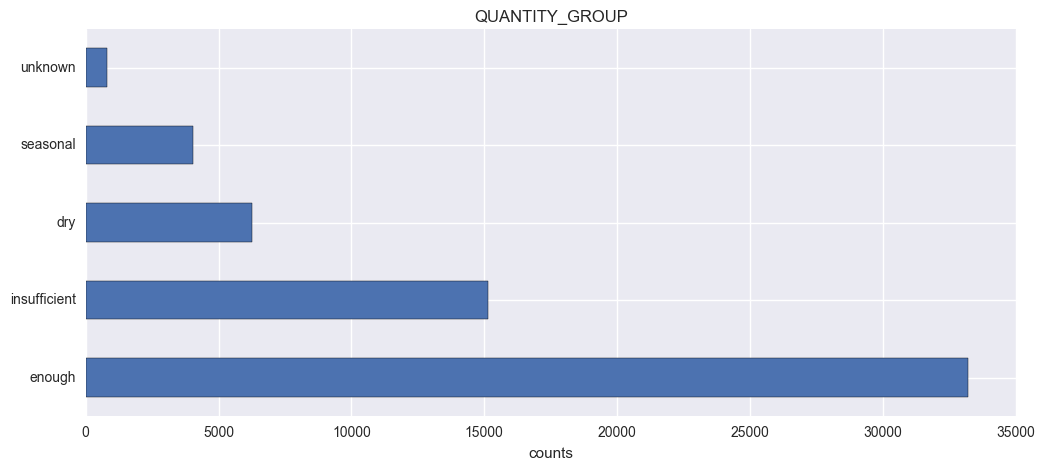

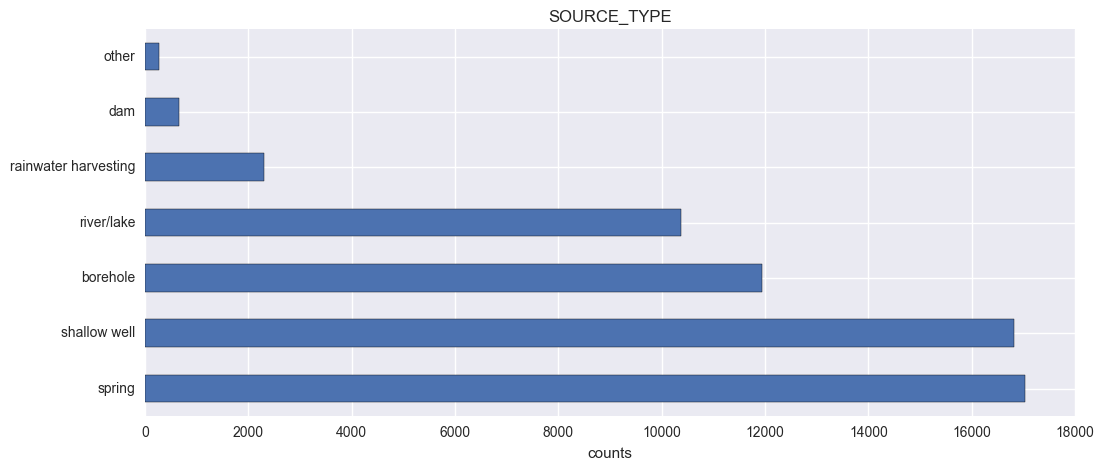

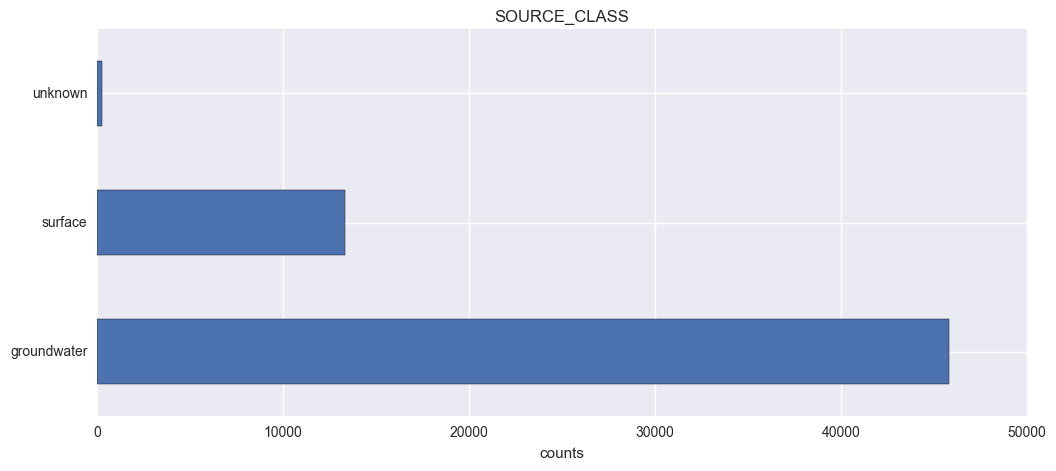

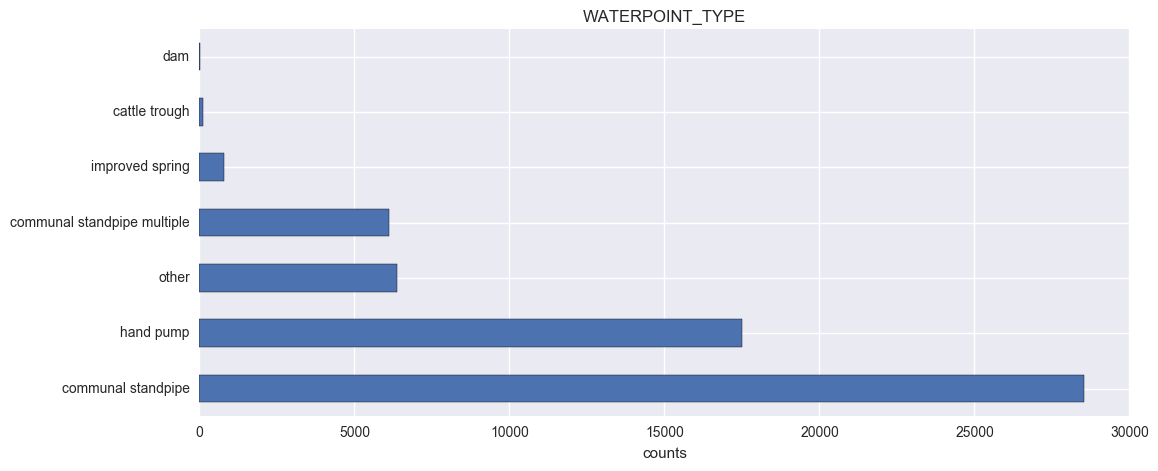

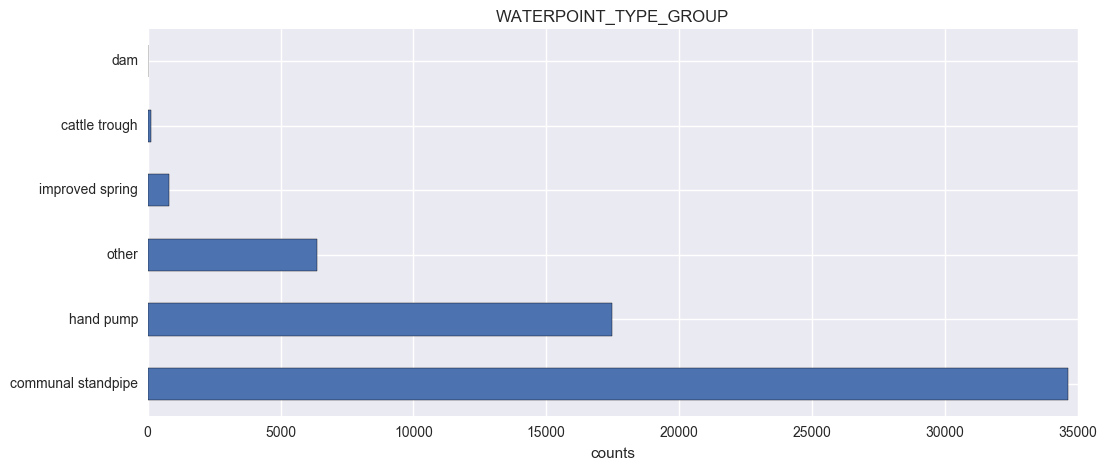

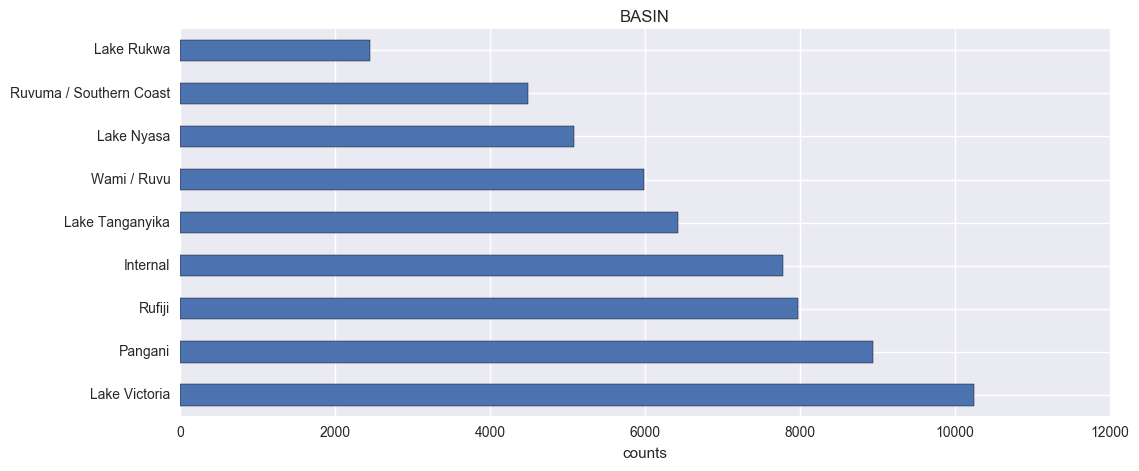

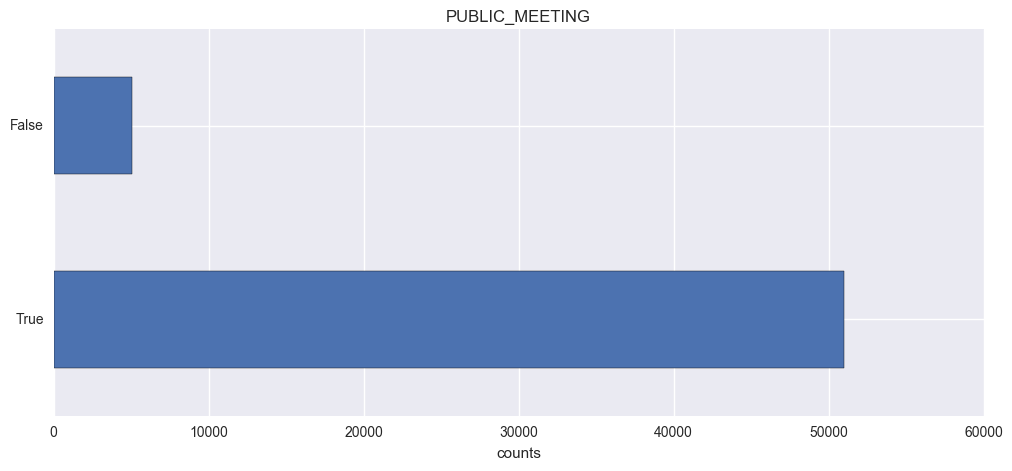

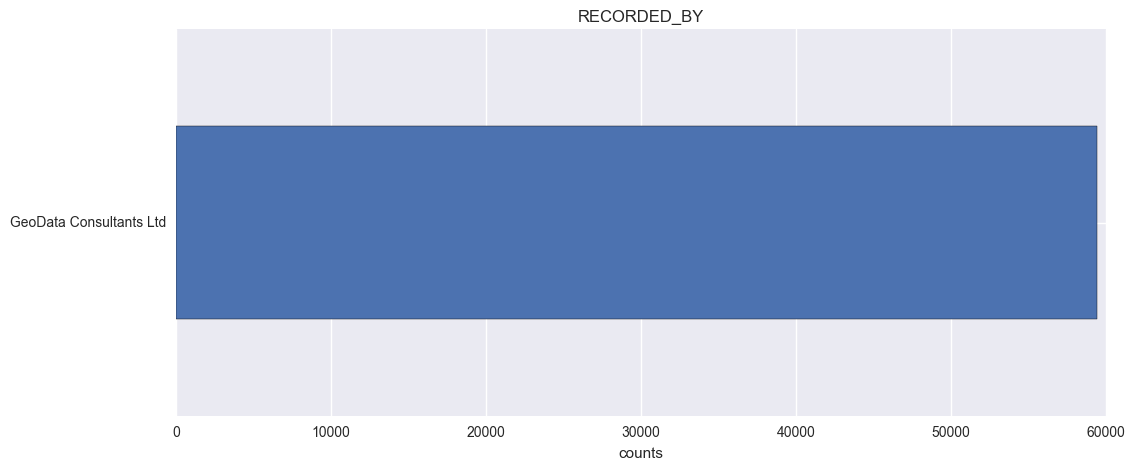

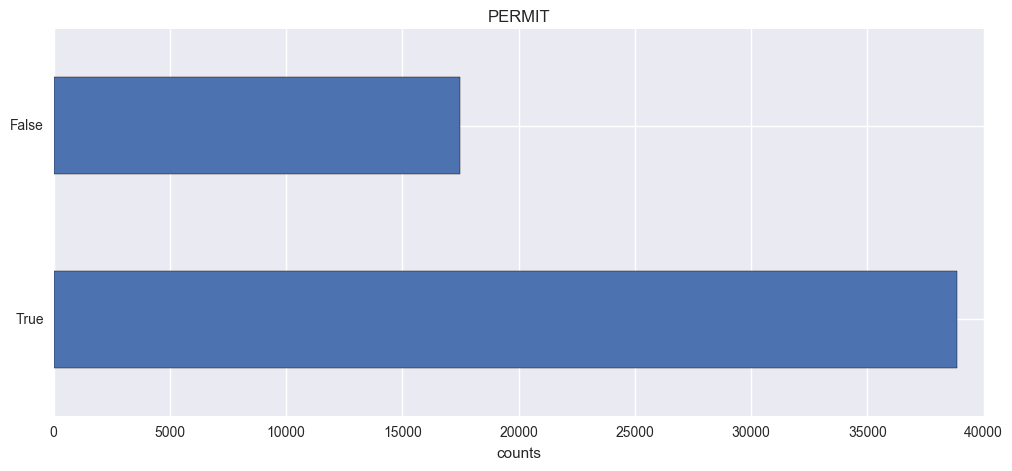

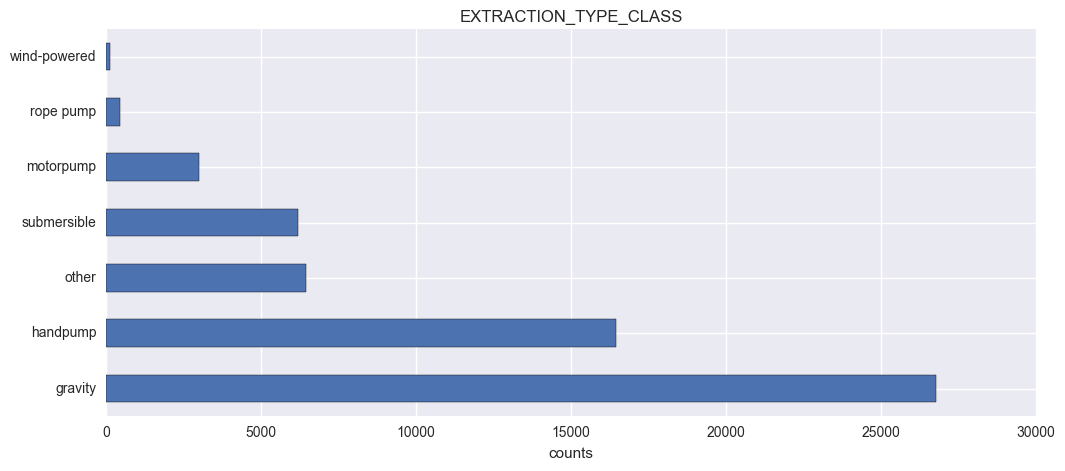

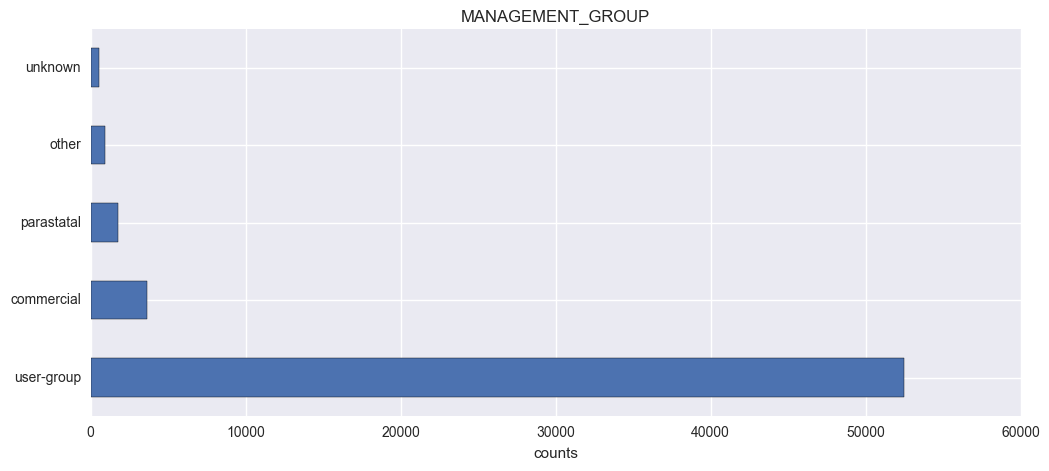

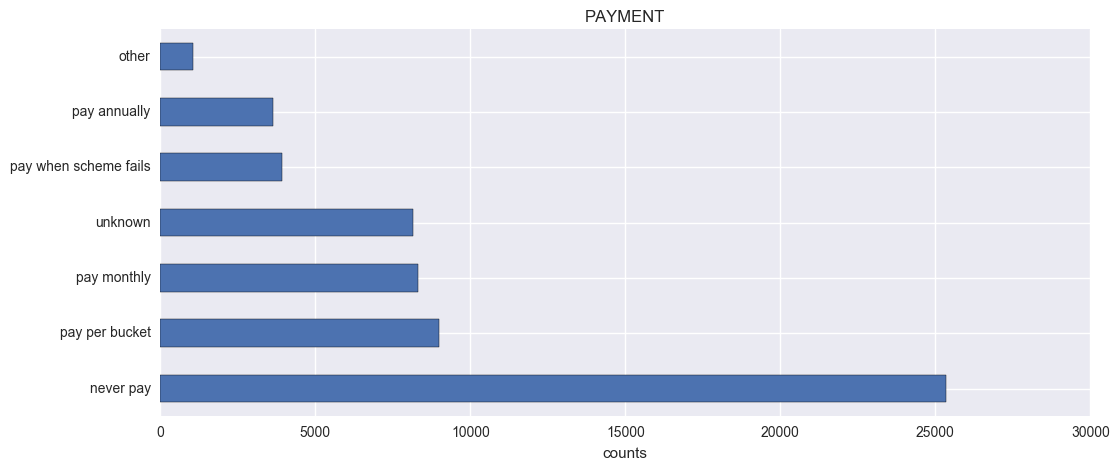

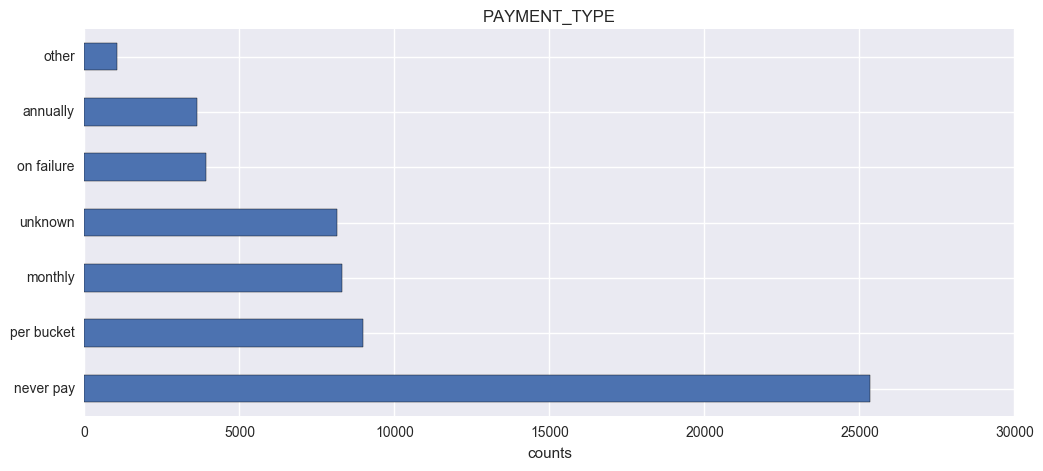

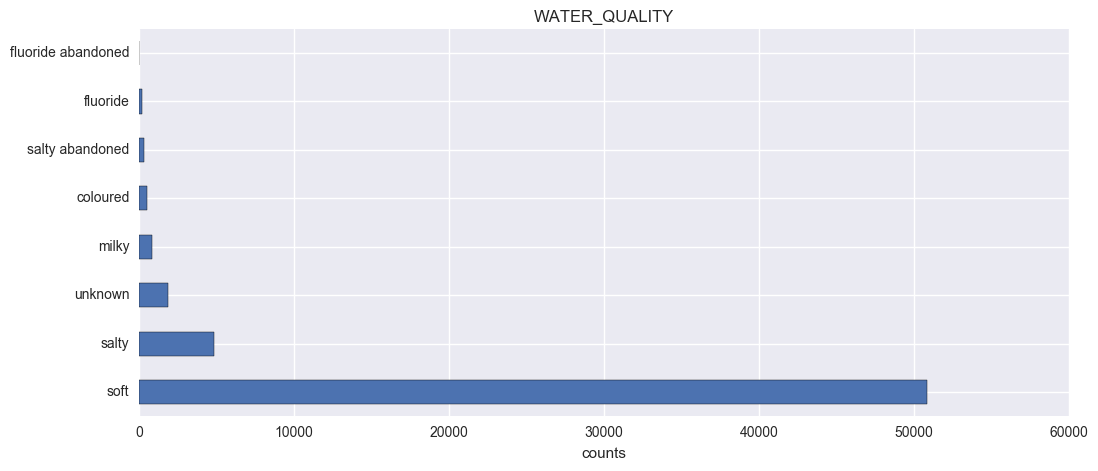

In [9]:
%%asmarkdown

# print '\n'.join(raw_markup_value_counts(RAW_X))

# show me the graphs
tmp = raw_markup_value_counts(RAW_X, 10, True)

## Pre Processing



1. Start_date

    Converting start_date from object type to integer, `2012-10-01` ==> 20121001

2. Longitude & Latitude

    Thirteen decimal places will pin down the location to 111,111/10^13 = about 1 angstrom, around half the thickness of a small atom.
    The sign tells us whether we are north or south, east or west on the globe.
    * A nonzero hundreds digit tells us we're using longitude, not latitude!
    * The tens digit gives a position to about 1,000 kilometers. It gives us useful information about what continent or ocean we are on.
    * The units digit (one decimal degree) gives a position up to 111 kilometers (60 nautical miles, about 69 miles). It can tell us roughly what large state or country we are in.
    * The first decimal place is worth up to 11.1 km: it can distinguish the position of one large city from a neighboring large city.
    * The second decimal place is worth up to 1.1 km: it can separate one village from the next.
    * The third decimal place is worth up to 110 m: it can identify a large agricultural field or institutional campus.
    * The fourth decimal place is worth up to 11 m: it can identify a parcel of land. It is comparable to the typical accuracy of an uncorrected GPS unit with no interference.

    As we dont need a higher accuracy than 4 digits, we are going trim to 4 digits.


Source: [Link](http://gis.stackexchange.com/questions/8650/measuring-accuracy-of-latitude-and-longitude)

* DateTime to Int
* Longititude/Latitude - Reduce precision

In [38]:
# datetime to number
RAW_X.date_recorded = RAW_X.date_recorded.apply( lambda x : int(x.replace('-', '')))

# reducing geo location precision to 11 meters
RAW_X.longitude = RAW_X.longitude// 0.0001
RAW_X.latitude = RAW_X.latitude// 0.0001

Fixing Boolean Values Null with False

In [40]:
RAW_X.public_meeting = RAW_X.public_meeting == True
RAW_X.permit = RAW_X.permit == True

Fixing minor text issues(upper case text -> lowercase)

In [41]:
for col in RAW_X.dtypes[RAW_X.dtypes == object].index:
    aa = len(RAW_X[col].unique())
    RAW_X[col] = RAW_X[col].fillna('').apply( lambda x : x.lower().strip())
    bb = len(RAW_X[col].unique())
    if aa != bb:
        print col, aa, bb

scheme_name 2697 2577


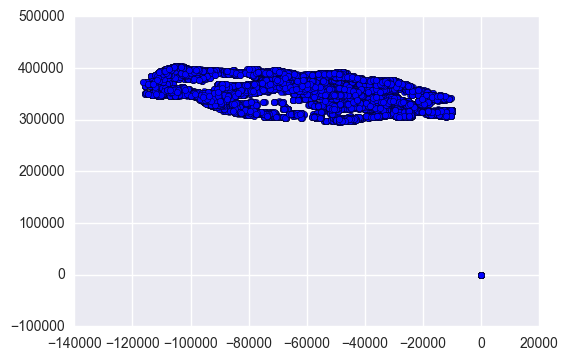

In [42]:
# RAW_X[[u'longitude', u'latitude']].plot()

plt.scatter(RAW_X[u'latitude'], RAW_X[u'longitude'])

As we can see, there is some data for which we do not know it geographical location

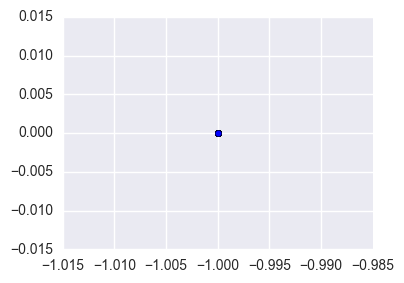

In [43]:
plt.figure(figsize=small)
_ = plt.scatter(RAW_X[u'latitude'][RAW_X.latitude >= -1.0], RAW_X[u'longitude'][RAW_X.latitude >= -1.0])

#

Working on reducing Categorical Values

In [47]:
RAW_X.head().T

id,69572,8776,34310,67743,19728
amount_tsh,6000,0,25,0,0
date_recorded,20110314,20130306,20130225,20130128,20110713
funder,roman,grumeti,lottery club,unicef,action in a
gps_height,1390,1399,686,263,0
installer,roman,grumeti,world vision,unicef,artisan
longitude,349380,346987,374606,384861,311308
latitude,-98564,-21475,-38214,-111553,-18254
wpt_name,none,zahanati,kwa mahundi,zahanati ya nanyumbu,shuleni
num_private,0,0,0,0,0
basin,lake nyasa,lake victoria,pangani,ruvuma / southern coast,lake victoria


In [68]:
# setting a limit factor of 100 categorical values are allowed

MAX_CATEGORICAL_GROUPS_LIMIT = 150

icols = {}
for col in RAW_X.dtypes[RAW_X.dtypes == object].index:
    tmp = len(RAW_X[col].unique())
    if tmp > MAX_CATEGORICAL_GROUPS_LIMIT:
        icols[col] = tmp
        
# %pprint on
icols

{'funder': 1898,
 'installer': 1936,
 'scheme_name': 2577,
 'subvillage': 19288,
 'ward': 2092,
 'wpt_name': 37399}

In [74]:
from collections import Counter

In [173]:
funder_dict =  Counter(RAW_X.funder)
tmp = funder_dict.keys()
tmp.sort()

In [177]:
%pprint on

Pretty printing has been turned OFF


In [179]:
funder_dict

Counter({'government of tanzania': 9084, '': 3635, 'danida': 3114, 'hesawa': 2202, 'rwssp': 1374, 'world bank': 1349, 'kkkt': 1287, 'world vision': 1246, 'unicef': 1057, 'tasaf': 877, 'district council': 843, 'dhv': 829, 'private individual': 826, 'dwsp': 811, '0': 777, 'norad': 765, 'germany republi': 610, 'tcrs': 602, 'ministry of water': 590, 'water': 583, 'dwe': 484, 'netherlands': 470, 'hifab': 450, 'adb': 448, 'lga': 442, 'amref': 425, 'fini water': 393, 'oxfam': 359, 'wateraid': 333, 'rc church': 321, 'isf': 316, 'rudep': 312, 'mission': 301, 'private': 295, 'jaica': 280, 'roman': 275, 'rural water supply and sanitat': 270, 'adra': 263, 'ces(gmbh)': 260, 'jica': 259, 'shipo': 241, 'wsdp': 234, 'rc': 230, 'finw': 219, 'dh': 213, 'ded': 198, 'plan int': 195, 'kiliwater': 189, 'dmdd': 186, 'go': 181, 'lawatefuka water supply': 180, 'oxfarm': 176, 'magadini-makiwaru water': 175, 'fw': 173, 'w.b': 170, 'kkkt_makwale': 166, 'ces (gmbh)': 165, 'wvt': 158, 'oikos e.afrika': 155, 'nethal

In [ ]:
tmp2 = Counter(tmp).keys()
tmp2.sort()
tmp2 = np.array(tmp2)
_ = plt.plot(tmp2)

As you can see, the spike in the start incdicates that we are having around ~1000 groups and each of these group member holds only one member

next step
* use diff lib on these top 1000 categories to for experiment

In [138]:
import difflib

In [142]:
tmp

['', '0', 'a/co germany', 'aar', 'abas ka', 'abasia', 'abc-ihushi development cent', 'abd', 'abdala', 'abddwe', 'abdul', 'abood', 'abs', 'aco/germany', 'acord', 'acord ngo', 'acra', 'act', 'act mara', 'action aid', 'action contre la faim', 'action in a', 'adap', 'adb', 'adf', 'adp', 'adp bungu', 'adp mombo', 'adp/w', 'adra', 'af', 'afdp', 'afric', 'africa', 'africa 2000 network/undp', 'africa amini alama', 'africa project ev germany', 'african', 'african 2000 network', 'african barrick gold', 'african development bank', 'african development foundation', 'african muslim agency', 'african realief committe of ku', 'african reflections foundation', 'african relie', 'africaone ltd', 'africare', 'afriican reli', 'afroz ismail', 'afya department lindi rural', 'agape churc', 'agt church', 'ahmadia', 'ai', 'aic', 'aic church', 'aic kij', 'aict', 'aimgold', 'aixos', 'alia', 'ambwene mwaikek', 'amref', 'amrefe', 'anglican church', 'angrikana', 'anjuman e seifee', 'answeer muslim grou', 'apm', 'ap

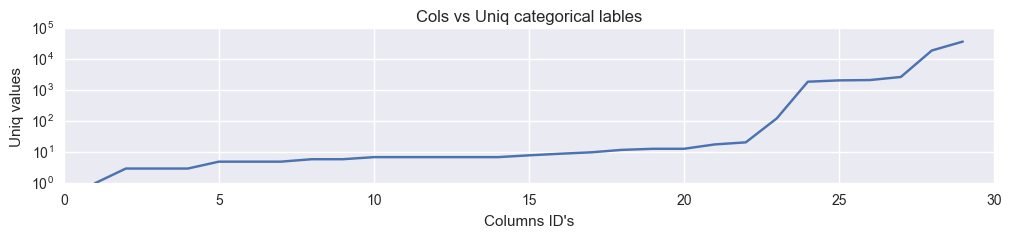

In [13]:
x = []
y = []
i = 0
for col in RAW_X.dtypes[RAW_X.dtypes == object].index:
    # print col, len(RAW_X[col].unique())
    i += 1
    x.append(i)
    y.append(len(RAW_X[col].unique()))


y.sort()

plt.figure(figsize=(12, 2))
plt.title('Cols vs Uniq categorical lables')
plt.xlabel('Columns ID\'s')
plt.ylabel('Uniq values')
_ = plt.semilogy(x, np.array(y))

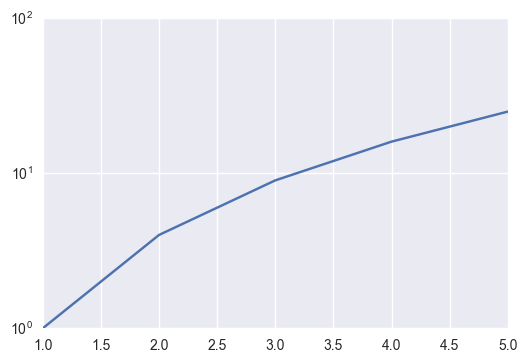

In [31]:
_ = plt.semilogy(x, np.array(y))

In [14]:
y = np.array(sorted(y))

(array([  1.,  14.,   7.,   0.,   1.,   0.,   0.,   4.,   0.,   2.]),
 array([  0.        ,   1.0529426 ,   2.1058852 ,   3.1588278 ,
          4.21177039,   5.26471299,   6.31765559,   7.37059819,
          8.42354079,   9.47648339,  10.52942598]),
 <a list of 10 Patch objects>)

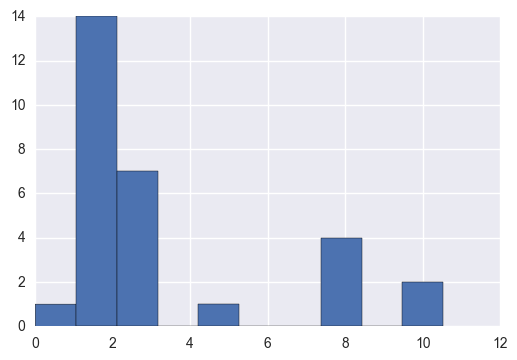

In [15]:
plt.hist(np.log(y))

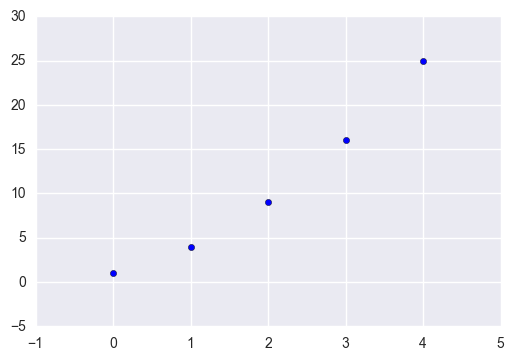

In [30]:
plt.scatter(np.arange(len(y)), y)

In [16]:
RAW_X.public_meeting = RAW_X.public_meeting == True
RAW_X.permit = RAW_X.permit == True

Fixing minor text issues(upper case text -> lowercase)

In [180]:
for col in RAW_X.dtypes[RAW_X.dtypes == object].index:
    aa = len(RAW_X[col].unique())
    RAW_X[col] = RAW_X[col].fillna('').apply( lambda x : x.lower().strip())
    bb = len(RAW_X[col].unique())
    if aa != bb:
        print col, aa, bb

### Understanding distribution of data

In [18]:
y = np.log(dict(RAW_X.installer.value_counts()).values())

print 'Total no.of unique values', len(y)
print 'Max', y.max()
print 'Min', y.min()
print 'Values more than 1', len(y[y > 0])

#_ = plt.plot(np.arange(len(y)), y)

Total no.of unique values 1936
Max 9.76451280025
Min 0.0
Values more than 1 962


In [19]:
# discard all minor values
y1 = y[y > 0]

# find the max limt for accepting
print y1.mean(), y1.std()
# _ = plt.hist(y1)

print 'with restpect to mean, 2 standard deviation', y1.mean() + (2 * y1.std())

2.21266085222 1.45919960747
with restpect to mean, 2 standard deviation 5.13106006715


with restpect to mean, 2 standard deviation 5.13106006715


(array([ 311.,   80.,  129.,   91.,   93.,   72.,   49.,   36.,   27.,   25.]),
 array([ 0.69314718,  1.13563184,  1.57811651,  2.02060117,  2.46308583,
         2.9055705 ,  3.34805516,  3.79053982,  4.23302449,  4.67550915,
         5.11799381]),
 <a list of 10 Patch objects>)

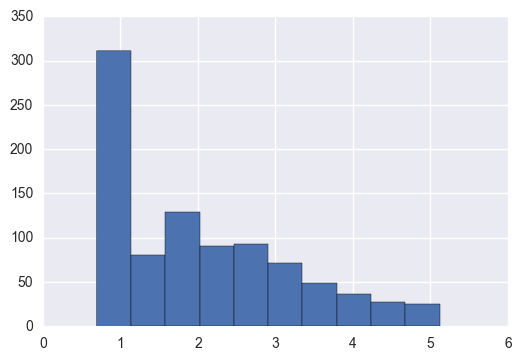

In [20]:
y = np.log(dict(RAW_X.installer.value_counts()).values())

# Discard all values appeared only once.
y = y[y > 0]

y = y[y <= 5.13106006715]

print 'with restpect to mean, 2 standard deviation', y1.mean() + (2 * y1.std())

plt.hist(y)

In [21]:
m = y1.mean()
s = y1.std()

for i in range(3):
    print m - (s * i), m + (s * i)

2.21266085222 2.21266085222
0.753461244751 3.67186045968
-0.705738362715 5.13106006715


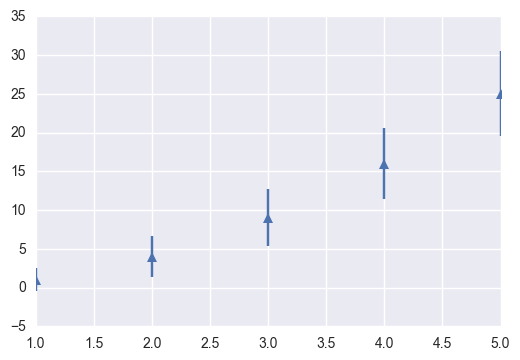

In [22]:
x = np.array([1, 2, 3, 4, 5])
y = np.power(x, 2) # Effectively y = x**2
e = np.array([1.5, 2.6, 3.7, 4.6, 5.5])

plt.errorbar(x, y, e, linestyle='None', marker='^')

plt.show()

Finding closely matching words

In [23]:
import difflib

tmp2 = difflib.get_close_matches('govern', tmp1, n=100, cutoff=0.66)
for each in tmp2:
    print '%s : %s' % (each, tmp[each])

NameError: name 'tmp1' is not defined

In [ ]:
RAW_X.head().T

## Vector Transformation

In [184]:
from collections import defaultdict
from sklearn import preprocessing

# http://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn
d = defaultdict(preprocessing.LabelEncoder)

# Labels Fit
sam = pd.concat([RAW_X, test_submission]).apply(lambda x: d[x.name].fit(x))

# Labels Transform - Training Data
X = RAW_X.apply(lambda x: d[x.name].transform(x))

# Labels Transform - Submission Data
# test_submission = test_submission.apply(lambda x: d[x.name].transform(x))

#
le = preprocessing.LabelEncoder().fit(RAW_y)
y = le.transform(RAW_y[u'status_group'])


/Users/sampathkumarm/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [185]:
print y[:5]

[0 0 0 2 0]


## Test-Train Split

In [187]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

/Users/sampathkumarm/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


/Users/sampathkumarm/anaconda/lib/python2.7/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


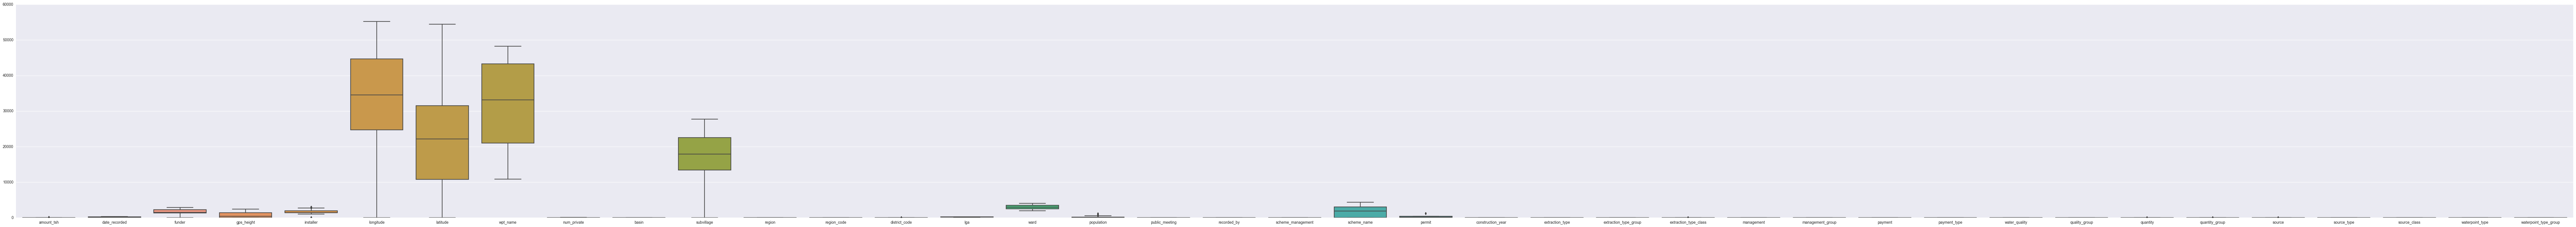

In [188]:
# X_train.boxplot()
plt.figure(figsize=(12,10))
_ = sb.boxplot(X_train)

# Model Training

## Random Forest

In [189]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

In [190]:
clf = clf.fit(X_train, y_train)
pred = clf.predict_proba(X_test)

In [220]:
clf.feature_importances_

array([ 0.02,  0.05,  0.03,  0.04,  0.02,  0.08,  0.07,  0.06,  0.  ,
        0.01,  0.05,  0.01,  0.01,  0.01,  0.02,  0.04,  0.03,  0.  ,
        0.  ,  0.01,  0.02,  0.02,  0.03,  0.01,  0.02,  0.01,  0.01,
        0.01,  0.01,  0.02,  0.01,  0.01,  0.08,  0.05,  0.01,  0.01,
        0.  ,  0.05,  0.03])

In [306]:
cols_imp = [(x,y) for x, y in zip(clf.feature_importances_, X_train.columns)]

In [308]:
cols_imp.sort(key=lambda x: x[0])

In [310]:
cols_imp

[(0.0, 'recorded_by'), (0.00064183716642762106, 'num_private'), (0.0039959740240181705, 'source_class'), (0.0046328167198293408, 'public_meeting'), (0.0052522197012455588, 'management_group'), (0.00926499512705398, 'water_quality'), (0.0094881170689621423, 'quality_group'), (0.010862252696016709, 'basin'), (0.010875760423827945, 'region_code'), (0.011172018651684592, 'scheme_management'), (0.011387826800668405, 'extraction_type'), (0.011817262756545526, 'source_type'), (0.012126442535360205, 'extraction_type_class'), (0.013096001391785553, 'payment'), (0.013343263791758117, 'source'), (0.013379555533544701, 'management'), (0.014193894299981339, 'region'), (0.014697820225805463, 'district_code'), (0.015638542145462578, 'extraction_type_group'), (0.015806827314454916, 'amount_tsh'), (0.016905451923036757, 'payment_type'), (0.020447230019172404, 'scheme_name'), (0.021361861527136445, 'lga'), (0.023924960748419481, 'permit'), (0.024223553810987935, 'installer'), (0.029610575928031863, 'fun

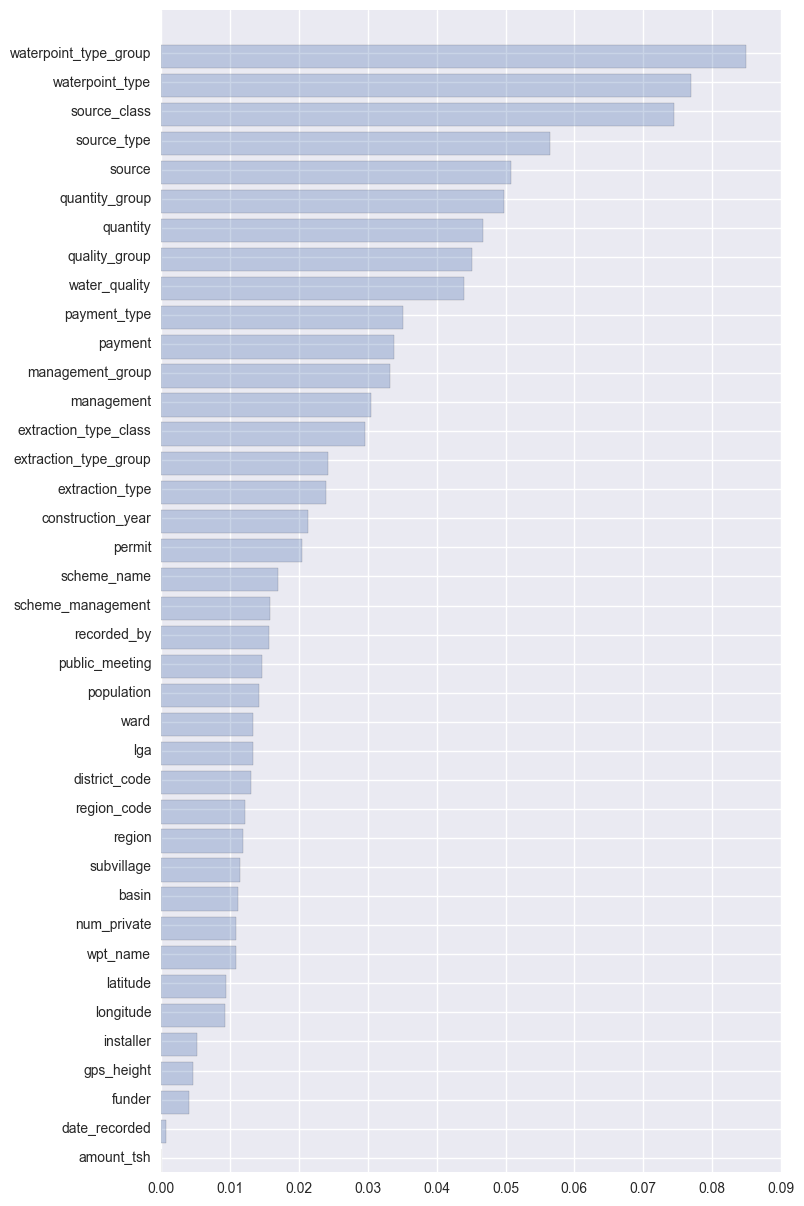

In [315]:


plt.figure(figsize=(8, 15))
values = [x[-2] for x in cols_imp]
lables = [x[-1] for x in cols_imp]

_ = plt.barh(range(len(values)), values, alpha=0.3)
_ = plt.yticks([_ + 0.5 for _ in range(len(values))], X_train.columns)

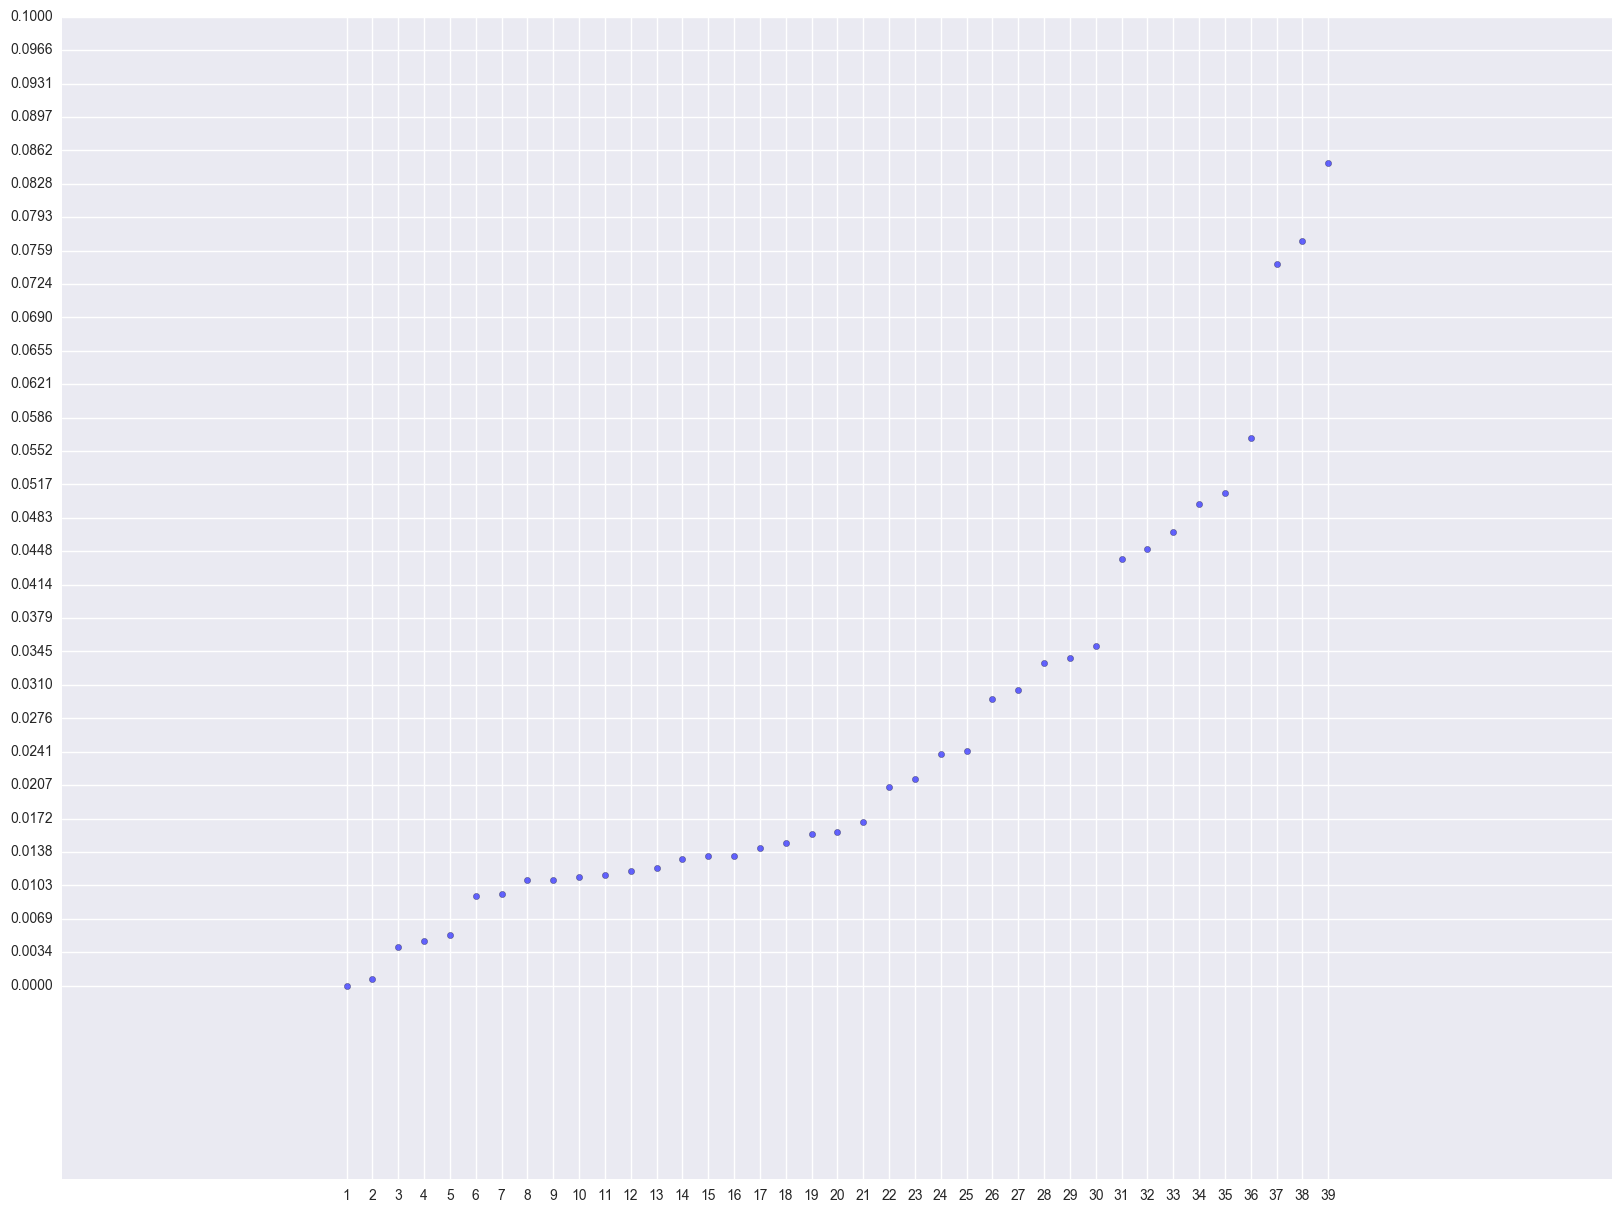

In [328]:
plt.figure(figsize=(20,15))
x = range(1, len(clf.feature_importances_) + 1)
y = np.linspace(0, 0.10, 30)
_ = plt.scatter(x, values, alpha=0.6)
_ = plt.xticks(x)
_ = plt.yticks(y)

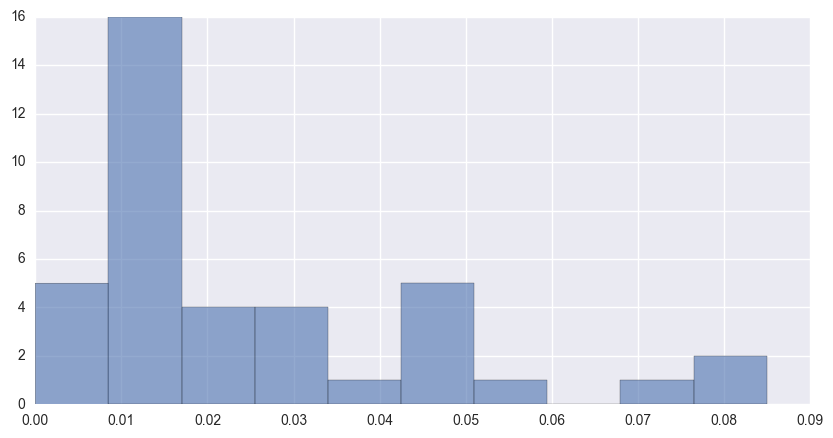

In [317]:
plt.figure(figsize=(10,5))

ax = plt.hist (values, alpha=0.6)

## Scoring

### Random Forest Score

In [196]:
# len(pred)

clf.score(X_test, y_test) # 0.79303132333435367

0.79797979797979801

In [197]:
from sklearn import metrics

Confusion matrix, without normalization
[[5756  170  526]
 [ 451  274  138]
 [1042   73 3450]]
Normalized confusion matrix
[[ 0.89  0.03  0.08]
 [ 0.52  0.32  0.16]
 [ 0.23  0.02  0.76]]


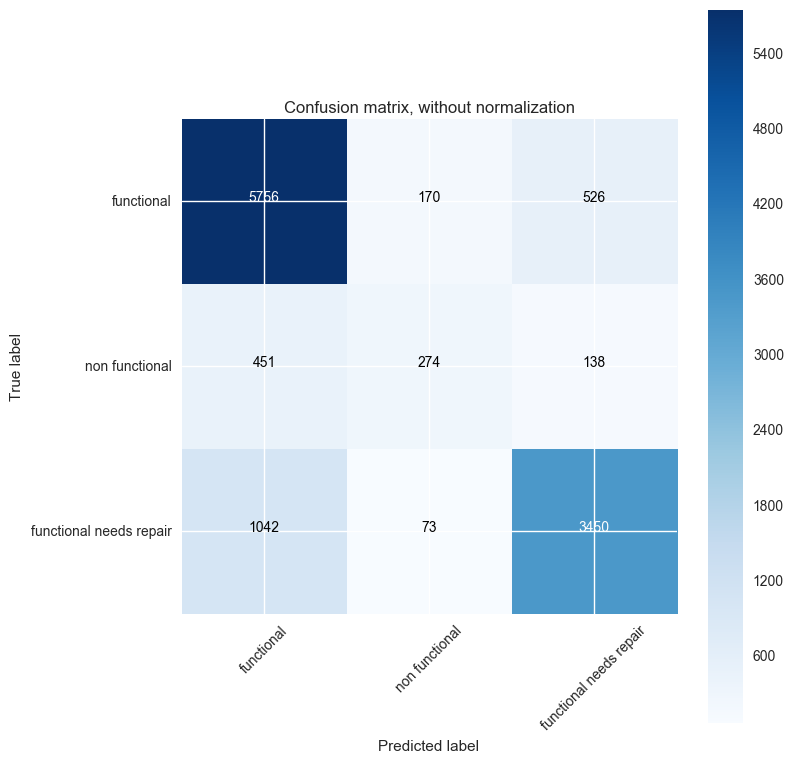

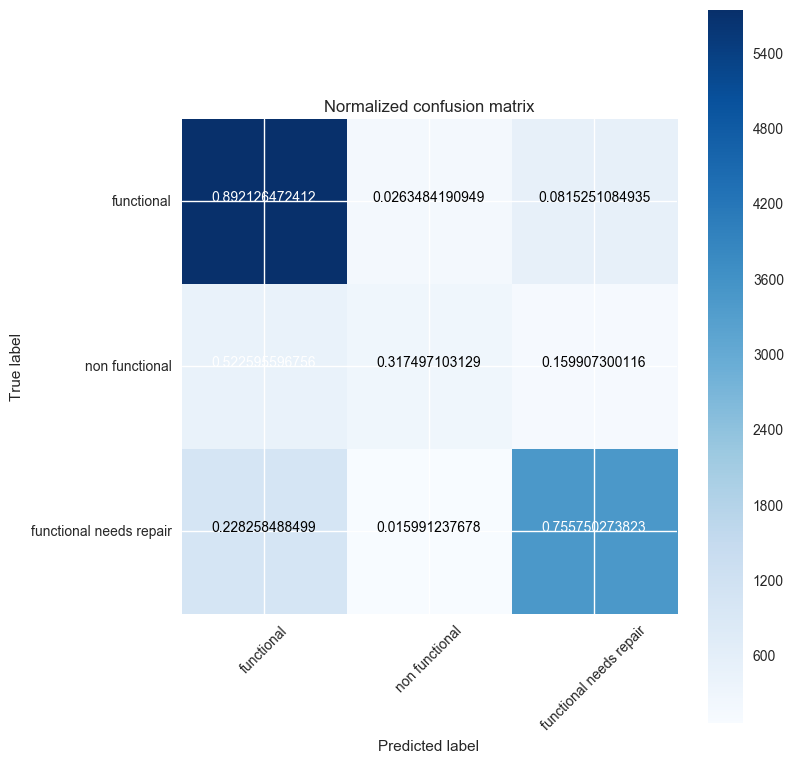

In [305]:
confusion_maxtrix_stuff(y_test, y_pred)

### AUC

In [329]:
print sum(y_pred == y_test)/ len(y_pred)

0.79797979798


In [204]:
sam = pd.DataFrame( y.copy())

sam[1] = sam[0] == 1
sam[2] = sam[0] == 2
sam[0] = sam[0] == 0

for i in range(3): sam[i] = sam[i].map(lambda x : 1 if x else 0)

## XGBOOST

In [213]:
import xgboost as xgb

In [284]:
# gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(X_train, y_train)
gbm = xgb.XGBClassifier(max_depth=3, n_estimators=100, learning_rate=0.05).fit(X_train, y_train)

In [285]:
gbm_predictions = gbm.predict(X_test)

print sum(gbm_predictions == y_test)/ len(y_pred) # 0.7279461279461279

Confusion matrix, without normalization
[[6096    1  355]
 [ 741   21  101]
 [2028    6 2531]]
Normalized confusion matrix
[[  9.45e-01   1.55e-04   5.50e-02]
 [  8.59e-01   2.43e-02   1.17e-01]
 [  4.44e-01   1.31e-03   5.54e-01]]


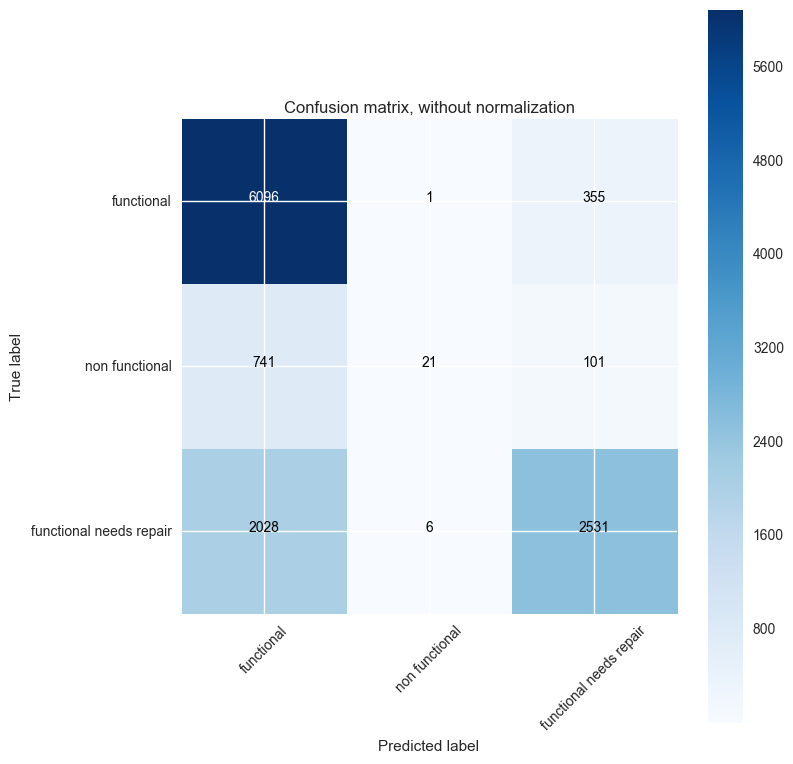

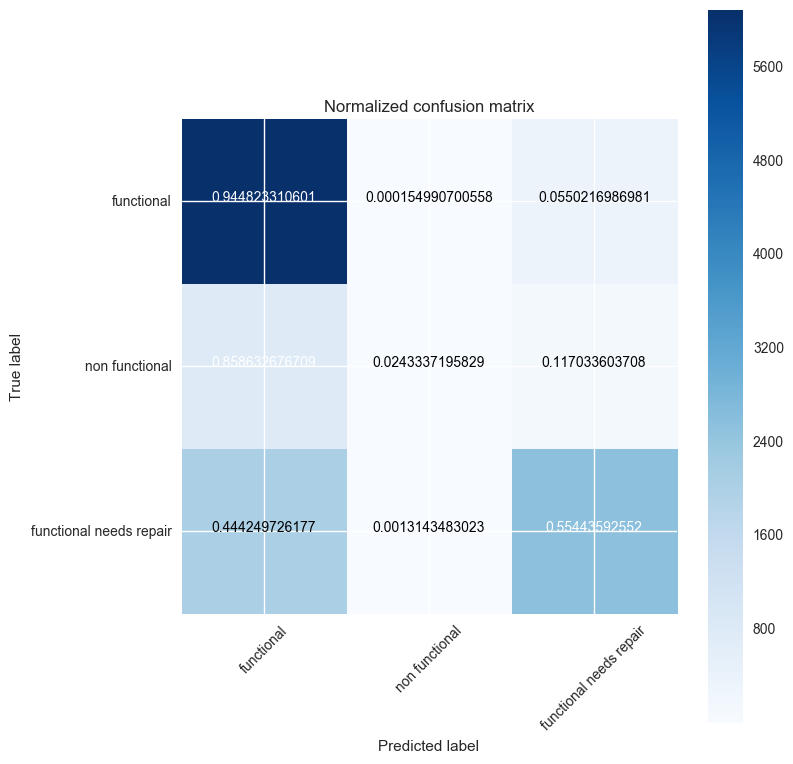

In [302]:
confusion_maxtrix_stuff(y_test, predictions)

# Submission

In [ ]:
test_ids = test_submission.index

# predictions = clf.predict_proba(test_submission)
predictions = clf.predict(test_submission)
print (predictions.shape)
predictions_labels = le.inverse_transform(predictions)
# sub = pd.DataFrame(predictions, columns=list(le.classes_))
sub = pd.DataFrame(predictions_labels, columns=['status_group'])
sub.head()

In [ ]:
sub.insert(0, 'id', test_ids)
sub.reset_index()
sub.to_csv('submit.csv', index = False)
sub.head()